In [1]:
%load_ext autoreload

In [434]:
%autoreload
import pandas as pd
import numpy as np
from Analyzers import EdgeDataAnalyzers
eda = EdgeDataAnalyzers.EdgeDataAnalyzer()
ca = EdgeDataAnalyzers.CentralityAnalyzer()
gv = EdgeDataAnalyzers.GraphVisualizer()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from Analyzers import MetaDataAnalyzer
mda = MetaDataAnalyzer.MetaDataAnalyzer()
import networkx as nx
import os

In [194]:
meta_df = pd.read_csv('Data/transformed_metadata.csv')

In [195]:
meta_df.head()

,reporter_citation,bench,case_title,cites_per_000_word,clean_catch_words,coram_1,coram_2,coram_3,coram_4,coram_5,...,has_topic_unincorporated associations and trade unions,has_topic_words and phrases,judgment_word_count,ls_cited_ages,ls_cited_cases,mean_cited_ages,neutral_citation,num_cited_cases,num_topics,num_citing_cases
0,[2010] 1 SLR 769,chan,"AAG v Estate of AAH, deceased",0.435667,"[['family law', 'legitimacy', 'effects of ille...",Chao Hick Tin JA,Andrew Phang Boon Leong JA,V K Rajah JA,NaN,NaN,...,0,0,6886.0,"[nan, nan, nan]","['[2007] 4 SLR(R) 183', '[1995] 1 SLR(R) 803',...",NaN,[2009] SGCA 56,3.0,2,1
1,[2007] 3 SLR(R) 592,chan,Abdul Jalil bin Ahmad bin Talib and others v A...,0.209908,"[['contract', 'consideration', 'forbearance', ...",Chan Sek Keong CJ,Andrew Phang Boon Leong JA,Tay Yong Kwang J,NaN,NaN,...,0,0,9528.0,"[nan, nan]","['[1998] 3 SLR(R) 720', '[1996] 1 SLR(R) 451']",NaN,[2007] SGCA 29,2.0,2,0
2,[2002] 1 SLR(R) 591,yong,Abdul Malik bin Abdul Jamil v Public Prosecutor,0.605205,"[['criminal law', 'statutory offences', 'misus...",Yong Pung How CJ,Chao Hick Tin JA,Tan Lee Meng J,NaN,NaN,...,0,0,4957.0,"[nan, nan, nan]","['[1993] 2 SLR(R) 771', '[1993] 3 SLR(R) 566',...",NaN,[2002] SGCA 19,3.0,2,0
3,[2001] 3 SLR(R) 355,yong,Aberdeen Asset Management Asia Ltd and another...,1.241355,"[['civil procedure', 'appeals', 'when time for...",Yong Pung How CJ,L P Thean JA,Chao Hick Tin JA,NaN,NaN,...,0,0,5639.0,"[112, nan, nan, nan, 422, nan, nan]","['[2001] 2 SLR(R) 246', '[1995] 2 SLR(R) 36', ...",267.0,[2001] SGCA 65,7.0,1,12
4,[2015] 2 SLR 420,menon,ABU v Comptroller of Income Tax,0.556306,"[['revenue law', 'international taxation', 'do...",Sundaresh Menon CJ,Chao Hick Tin JA,Andrew Phang Boon Leong JA,NaN,NaN,...,0,0,12583.0,"[nan, nan, 363, 637, nan, nan, 86]","['[2014] 1 SLR 123', '[2013] 4 SLR 801', '[201...",362.0,[2015] SGCA 4,7.0,2,1


global stats - mean, sd: cases per topic (top 20 and others), word count, citations received, citations given, citations received per word, citations given per word, num_cases

In [196]:
cols_to_tabulate=['judgment_word_count',
                    'num_cited_cases',
                    'num_citing_cases',
                    'cites_per_000_word',
                 ]
global_stats = np.round(mda.tabulate_global_stats(meta_df,
    cols_to_tabulate=cols_to_tabulate), 4)

global_stats.columns = ['All Cases']
global_stats.loc['_size'] = meta_df.shape[0]
global_stats.index = pd.Series(global_stats.index).apply(eda.readify_varnames)

Combine with stats by bench

In [200]:
bench_stats = meta_df.groupby('bench').agg({'judgment_word_count': [np.mean,np.std],
                         'num_cited_cases': [np.mean, np.std],
                         'num_citing_cases': [np.mean, np.std],
                         'cites_per_000_word': [np.mean, np.std, np.size]
}).apply(np.round, axis=1, args=(4,)).transpose()[['yong','chan','menon']]
for x_i in bench_stats.index:
    if x_i[-1] == 'std':
        bench_stats.loc[x_i] = bench_stats.loc[x_i].apply(lambda x: '('+str(np.round(x,4))+')')
bench_stats = bench_stats.reset_index()
bench_stats.index = bench_stats['level_0'] + '_' +bench_stats['level_1']
bench_stats.index.name = None
bench_stats.index = pd.Series(bench_stats.index).apply(eda.readify_varnames)
bench_stats = bench_stats.drop(['level_0', 'level_1'], axis=1)
bench_stats.columns = [x.title()+' Bench' for x in bench_stats.columns]
bench_stats['Overall'] = global_stats
bench_stats.loc['Years In Sample'] = [6,6,6,18]
bench_stats.to_latex('Tables/bench_stats.tex')
bench_stats

,Yong Bench,Chan Bench,Menon Bench,Overall
Word Count,6172.84,12128.1,13253,10581.9
,(3415.9859),(8872.3849),(8033.194),(7879.251)
Outward Citations,3.2413,7.2133,8.0932,6.2229
,(3.3049),(6.4119),(5.1206),(5.571)
Inward Citations,2.0762,3.072,1.1994,2.16413
,(2.4313),(3.8283),(1.977),(3.01)
Outward Citations Per '000 Words,0.628,0.6624,0.7293,0.672529
,(0.6675),(0.4735),(0.5161),(0.556)
Observations In Sample,315,361,311,987
Years In Sample,6,6,6,18


In [201]:
yearly_stats = np.round(eda.tabulate_time_series(meta_df, 
                                        ['judgment_word_count','num_cited_cases', 'num_citing_cases', 'cites_per_000_word',],
                                        'decision_year'), 4)
yearly_stats = eda.format_groupby_for_pub(yearly_stats)
yearly_stats.columns.name = 'Year Decided'
yearly_stats.to_latex('Tables/yearly_stats.tex')
yearly_stats

Year Decided,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Word Count,7375.49,6028.78,5408.07,5197.3,5720.29,6712.83,8283.65,11632.3,14838.1,13877.2,11634.1,10937,11560.5,13333.4,12665.9,14269.8,13251.1,12905.7
,(2994.9652),(3139.5919),(3515.9944),(2418.1187),(4383.3662),(3448.2896),(5386.9193),(7245.3026),(10833.8431),(11320.9406),(8478.876),(8271.9469),(6974.0452),(8073.531),(6101.541),(9537.5846),(7708.619),(8532.5701)
Outward Citations,2.9672,2.4655,2.1333,3.175,3.551,5.0417,4.3256,7.9821,7.5417,8.4754,6.898,6.2931,7.5806,9.0377,7.75,7.5323,7.8636,8.2941
,(3.2963),(2.3931),(2.2724),(3.6154),(3.4221),(4.1255),(3.4207),(8.5141),(5.9249),(7.5291),(5.4476),(5.8219),(5.1805),(5.6431),(4.7251),(4.4009),(4.7907),(5.9276)
Inward Citations,1.7377,2.4828,1.6,1.875,1.9592,2.4792,3.2558,4.625,4.0833,3.6721,1.9388,2,2.0161,2.5094,1.45,1.2903,0.7727,0.2647
,(2.1362),(2.7289),(2.1992),(2.4093),(2.1695),(2.6657),(4.215),(4.5629),(5.2016),(3.7847),(2.2118),(2.7274),(2.2213),(3.566),(1.3331),(1.6335),(1.2127),(0.5358)
Outward Citations Per '000 Words,0.4573,0.5097,0.4987,0.7551,0.7649,0.8488,0.6161,0.6993,0.6128,0.655,0.7446,0.5965,0.7286,0.8252,0.7215,0.6398,0.6788,0.7748
,(0.5461),(0.5923),(0.5817),(0.9031),(0.6649),(0.7293),(0.4906),(0.5017),(0.4149),(0.414),(0.5855),(0.4021),(0.4918),(0.6802),(0.5085),(0.4465),(0.4464),(0.4827)
Observations In Sample,61,58,45,40,49,48,43,56,48,61,49,58,62,53,60,62,66,68


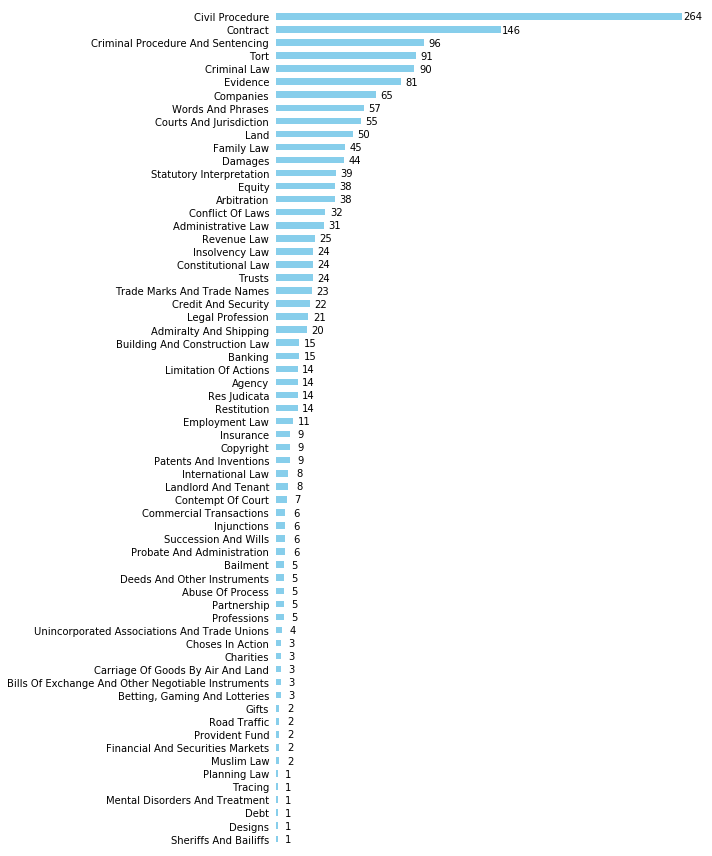

In [202]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + 7
            _y = p.get_y()
            value = '{:.0f}'.format(p.get_width())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

topic_cols = [col for col in meta_df.columns if col.startswith('has_topic')]
topic_counts = meta_df[topic_cols].sum().sort_values(ascending=True)
topic_counts.index = [x.replace('has_topic','').replace('_', ' ').title().strip() for x in topic_counts.index]
plt.figure(figsize=(10,12))
ax = topic_counts.plot(kind='barh', color='skyblue')

### stuff to dejunk the plot
show_values_on_bars(ax)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='off')

plt.tight_layout()
plt.savefig('Images/charts/global_topic_counts.png')

In [203]:
most_freq_topics = pd.Series(topic_counts.sort_values(ascending=False).index[0:10].values)
most_freq_topics_colnames = most_freq_topics.apply(lambda x: ('has_topic_'+x.lower()).strip())
topic_colnames = ['has_topic_civil procedure','has_topic_contract','has_topic_criminal procedure and sentencing',
                  'has_topic_tort', 'has_topic_criminal law', 'has_topic_evidence', 'has_topic_companies',
                  'has_topic_words and phrases', 'has_topic_words and phrases', 'has_topic_courts and jurisdiction'
                 ]
mda.tabulate_topical_stats(meta_df, cols_to_tabulate, topic_colnames).transpose()

civil procedure (264, 87)
companies (65, 87)
contract (146, 87)
courts and jurisdiction (55, 87)
criminal law (90, 87)
criminal procedure and sentencing (96, 87)
evidence (81, 87)
tort (91, 87)
words and phrases (57, 87)


,mean,std
civil procedure_judgment_word_count,9416.761364,7779.770308
civil procedure_num_cited_cases,6.386364,5.336078
civil procedure_num_citing_cases,2.526515,3.102688
civil procedure_cites_per_000_word,0.799682,0.610559
companies_judgment_word_count,11132.584615,7502.283998
companies_num_cited_cases,5.230769,4.450313
companies_num_citing_cases,2.369231,3.028868
companies_cites_per_000_word,0.453452,0.262176
contract_judgment_word_count,11924.246575,7527.864789
contract_num_cited_cases,6.089041,5.406154


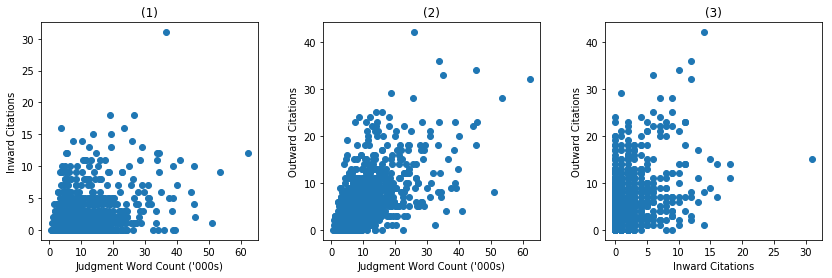

In [199]:
fig = plt.figure(figsize=(14,4))
plt.subplot(131)
plt.scatter(meta_df['judgment_word_count'] /1000, meta_df['num_citing_cases'])
plt.xlabel('Judgment Word Count (\'000s)')
plt.ylabel('Inward Citations')
plt.title('(1)')
plt.subplot(132)
plt.scatter(meta_df['judgment_word_count'] /1000, meta_df['num_cited_cases'])
plt.ylabel('Outward Citations')
plt.xlabel('Judgment Word Count (\'000s)')
plt.title('(2)')
plt.subplot(133)
plt.scatter(meta_df['num_citing_cases'], meta_df['num_cited_cases'])
plt.xlabel('Inward Citations')
plt.ylabel('Outward Citations')
plt.title('(3)')
plt.subplots_adjust(wspace=0.30)
plt.savefig('Images/cite_scatters.png')

In [626]:
meta_df[cols_to_tabulate].corr()

,judgment_word_count,num_cited_cases,num_citing_cases,cites_per_000_word
judgment_word_count,1.000000,0.576522,0.312418,-0.204217
num_cited_cases,0.576522,1.000000,0.347279,0.502083
num_citing_cases,0.312418,0.347279,1.000000,0.092693
cites_per_000_word,-0.204217,0.502083,0.092693,1.000000


In [860]:
table = pd.DataFrame()
for topic in topic_colnames:
    topic_data =  meta_df.groupby(topic)[cols_to_tabulate].agg([np.mean, np.std, np.size])
    has_topic_data = topic_data.loc[1]
    table[topic] = has_topic_data

topic_stats = eda.format_groupby_for_pub(np.round(table,4)).transpose()
#drop extra obs columns as we apply np.count every time
topic_stats.columns = ['drop' if x == 'Observations In Sample' else x for x in topic_stats.columns[:-1]] + ['Observations In Sample']
topic_stats = topic_stats.drop('drop', axis=1)

#all this work to properly place std below the respective columns
topic_stats.columns = ['std_{}'.format(topic_stats.columns[i-1]) if x == '' else x for i, x in enumerate(topic_stats.columns)]
sds = topic_stats[[col for col in topic_stats if col.startswith('std')]]
topic_stats = topic_stats.drop([col for col in topic_stats if col.startswith('std')], axis=1)
for topic in topic_colnames:
    for stat in topic_stats:
        if stat.lower().startswith('obs'):
            continue
        topic_stats.loc[topic+'_std', stat] = sds.loc[topic, 'std_'+stat]

# need to sort them back in place so they appear correctly
topic_stats = topic_stats.sort_index().fillna(method='ffill')
topic_stats['colFromIndex'] = topic_stats.index
topic_stats = topic_stats.sort_values(['Observations In Sample', 'colFromIndex'], ascending=True).drop('colFromIndex', axis=1)

# finally, std are right...
topic_stats['Observations In Sample'] = topic_stats['Observations In Sample'].astype(int)
topic_stats['Observations In Sample'] = ['' if (i+1)%2==0 else val for i, val in enumerate(topic_stats['Observations In Sample'])]
topic_stats.index = [eda.readify_varnames(x) for x in topic_stats.index]
topic_stats.to_latex('Tables/topic_stats.tex')
topic_stats

,Judgment Word Count,No. Of Outgoing Citations,No. Of Incoming Citations,No. Of Outgoing Citations Per Thousand Words,Observations In Sample
Courts And Jurisdiction,13040.8,9.6727,4.1818,0.9491,55
,(12002.4077),(7.4834),(3.6519),(0.6445),
Words And Phrases,11227.8,5.4211,2.5263,0.4723,57
,(10749.1161),(6.3159),(3.3118),(0.3684),
Companies,11132.6,5.2308,2.3692,0.4535,65
,(7502.284),(4.4503),(3.0289),(0.2622),
Evidence,12390.3,7.8765,2.7037,0.6964,81
,(9995.4226),(7.5753),(3.2956),(0.5711),
Criminal Law,11625.1,9.3,2.2667,0.9137,90
,(10253.8431),(8.0997),(2.7957),(0.6537),


In [417]:
meta_df.groupby('has_topic_tort')[cols_to_tabulate].agg([np.mean, np.std, np.size])

judgment_word_count                      num_cited_cases  \
                              mean           std   size            mean   
has_topic_tort                                                            
0                     10099.283482   7436.514949  896.0        6.060268   
1                     15334.153846  10249.412011   91.0        7.824176   

                                num_citing_cases                 \
                     std   size             mean       std size   
has_topic_tort                                                    
0               5.485455  896.0         2.051339  2.944105  896   
1               6.158271   91.0         3.274725  3.419116   91   

               cites_per_000_word                   
                             mean       std   size  
has_topic_tort                                      
0                        0.685213  0.566701  896.0  
1                        0.547647  0.419380   91.0

In [437]:
mda.get_perc_with_sole_topic(meta_df, 'has_topic_contract')

0.3493150684931507

time series plot of word count, num_cases, num_cited, cites_per_word, mean_cited_ages

note that graph is not used in the paper

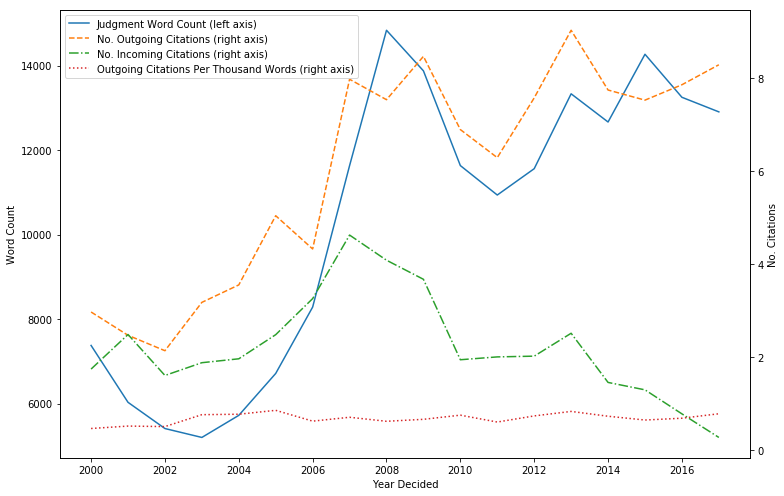

In [464]:
def standardize(pd_srs):
    return (pd_srs - pd_srs.mean()) / pd_srs.std()

yearly = meta_df.groupby('decision_year')[['judgment_word_count','num_cited_cases', 'num_citing_cases', 'cites_per_000_word',]].agg(np.mean)
fig, ax = plt.subplots(figsize=(11,7))
ax1 = yearly['judgment_word_count'].plot(ax=ax, label='Judgment Word Count (left axis)')
ax1.set_ylabel('Word Count')
ax2 = yearly['num_cited_cases'].plot(ax=ax, secondary_y=True, linestyle='--')
ax2 = yearly['num_citing_cases'].plot(ax=ax, secondary_y=True, linestyle='-.')
ax2 = yearly['cites_per_000_word'].plot(ax=ax, secondary_y=True, linestyle=':')
plt.legend((ax1.lines[0],ax2.lines[0], ax2.lines[1], ax2.lines[2]), ('Judgment Word Count (left axis)',
                                                      'No. Outgoing Citations (right axis)',
                                                      'No. Incoming Citations (right axis)',
                                                      'Outgoing Citations Per Thousand Words (right axis)',))
ax1.set_xlabel('Year Decided')
ax2.set_ylabel('No. Citations')
# this is simply to make the years display as ints
from matplotlib.ticker import MaxNLocator
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig('Images/charts/wordcount_time_series.png')
plt.show()

To produce lagged correlations presented in the paper

In [513]:
for i in range(0,4):
    print(yearly['num_citing_cases'].corr(
        yearly['judgment_word_count'].shift(-i)))

0.0824451299396
0.29028056386
0.325144628024
0.188763668041


heatmap of case load presented as Figure 1

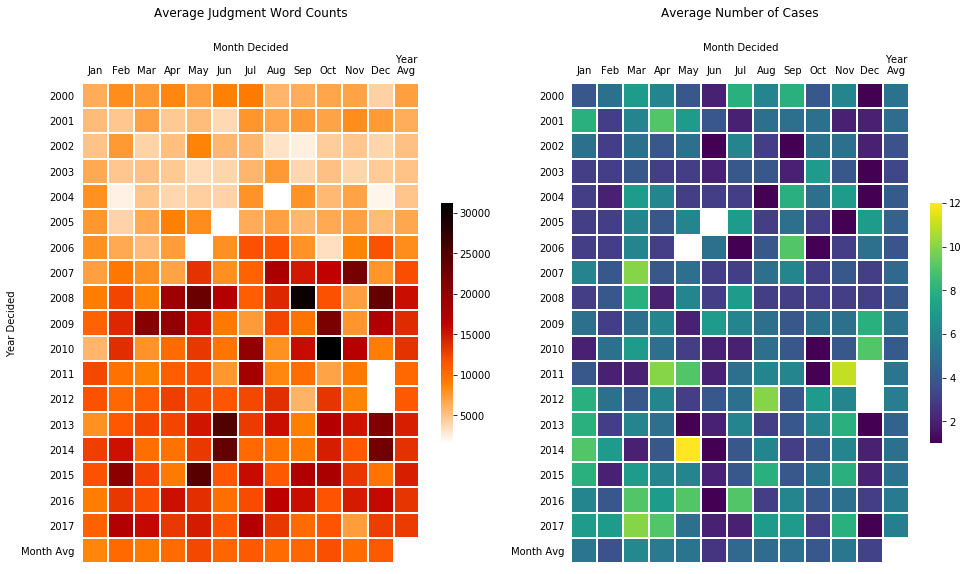

In [541]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
hmap1, ax1 = mda.plot_yearmonth_map(ax1, meta_df, 'judgment_word_count', with_rowmeans=True, with_colmeans=True, cbar_kws={'shrink':0.5})
hmap2, ax2 = mda.plot_yearmonth_map(ax2, meta_df, 'case_title', np.size, with_rowmeans=True, with_colmeans=True, cbar_kws={'shrink':0.5})
ax2.set_ylabel('')
ax1.set_title('Average Judgment Word Counts', y = 1.125)
ax2.set_title('Average Number of Cases', y = 1.125)
plt.tight_layout()
plt.savefig('Images/charts/num_cases_word_heat.png')

In [731]:
meta_df[(meta_df['has_topic_civil procedure'] == 1) | (meta_df['has_topic_criminal procedure and sentencing']==1)][[col for col in meta_df.columns if col.startswith('has_topic')]].sum(axis=1).value_counts()

2    133
1    129
3     65
4     21
5      8
6      2
7      1
dtype: int64

In [7]:
mda.get_stats_by_topic_num(meta_df, 'evidence', 1)

,judgment_word_count,num_cited_cases,num_citing_cases,cites_per_000_word
count,8.000000,8.000000,8.000000,8.000000
mean,7670.500000,4.125000,0.625000,0.500264
std,5333.256068,3.603074,0.744024,0.349171
min,1963.000000,0.000000,0.000000,0.000000
25%,3945.000000,2.250000,0.000000,0.260900
50%,6279.500000,3.500000,0.500000,0.627607
75%,9650.000000,6.000000,1.000000,0.747608
max,17248.000000,11.000000,2.000000,0.868810


Overall graph plots. Only the directed graph global plot is used

In [418]:
g = gv.prepare_graph(edge_df, 'citing_id', 'cited_id', create_using=nx.Graph())
g, importance = gv.prepare_plot(g, importance_thresh=3)

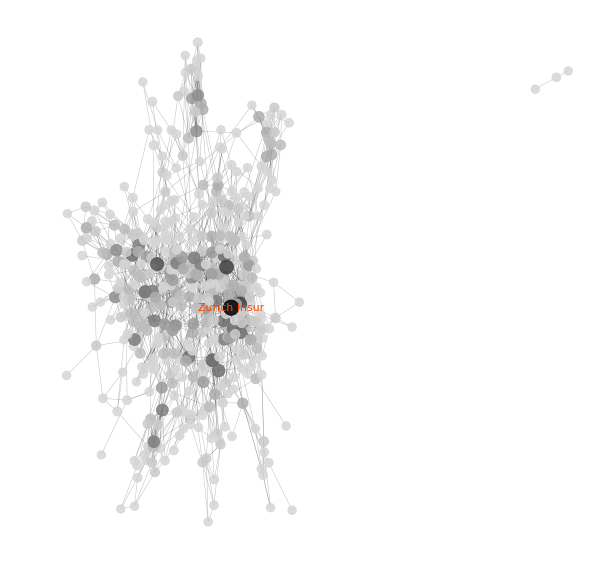

In [419]:
fig, ax = plt.subplots(figsize=(10,10))
ax = gv.plot_graph(ax, g, importance, size_multiplier=5, with_labels=True, edge_kwargs={'width':0.5,'alpha':0.25})

In [10]:
imp_thresh = 1
dg = gv.prepare_graph(edge_df, 'citing_id', 'cited_id', create_using=nx.DiGraph())
sub_dg, sub_importance = gv.prepare_plot(dg, importance_thresh=imp_thresh)

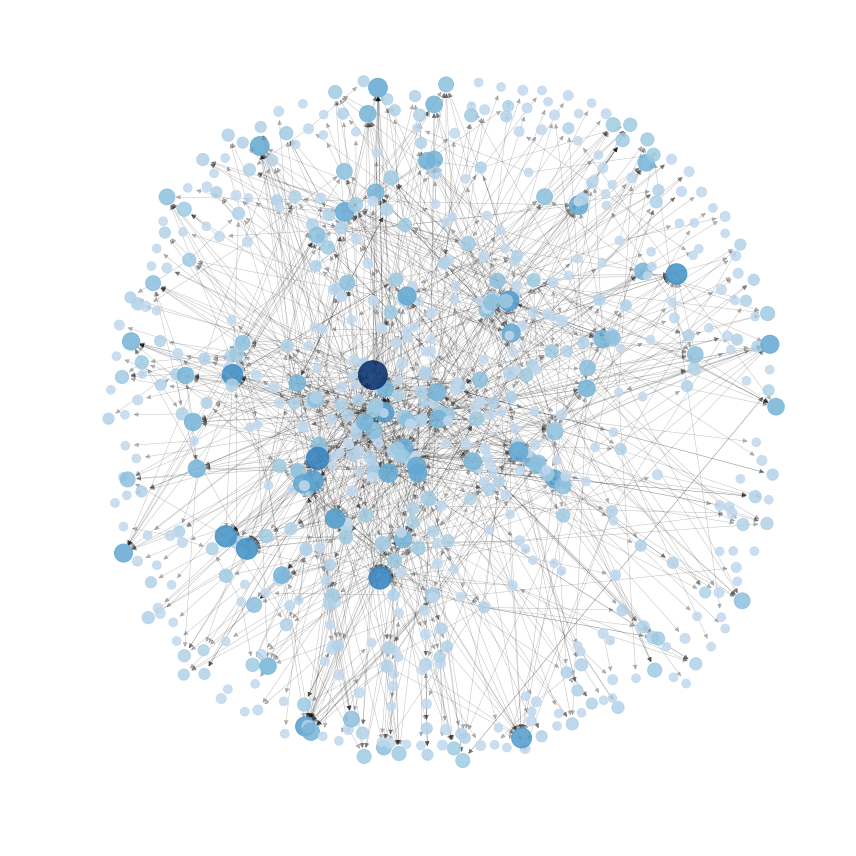

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
gv.plot_graph(ax, sub_dg, sub_importance, size_multiplier=25, edge_kwargs={'width':0.5,'alpha':0.25})
plt.tight_layout()
plt.savefig('Images/graphs/overall_directed_imp_thresh_{}.png'.format(imp_thresh))

Central cases - overall

In [258]:
all_cent = ca.get_centrality_df(dg)

In [430]:
all_rank_scores = ca.get_rank_scores(all_cent, meta_df, 'authority_score').head(10)

In [433]:
all_rank_scores.case_title.tolist()

['Zurich Insurance (Singapore) Pte Ltd v B-Gold Interior Design & Construction Pte Ltd [2008] 3 SLR(R) 1029',
 'Sembcorp Marine Ltd v PPL Holdings Pte Ltd and another and another appeal [2013] 4 SLR 193',
 'Sandar Aung v Parkway Hospitals Singapore Pte Ltd (trading as Mount Elizabeth Hospital) and another [2007] 2 SLR(R) 891',
 'Panwah Steel Pte Ltd v Koh Brothers Building & Civil Engineering Contractor (Pte) Ltd [2006] 4 SLR(R) 571',
 'Man Financial (S) Pte Ltd (formerly known as E\xa0D & F\xa0Man International (S) Pte Ltd) v Wong Bark Chuan David [2008] 1 SLR(R) 663',
 'RDC Concrete Pte Ltd v Sato Kogyo (S) Pte Ltd and another appeal [2007] 4 SLR(R) 413',
 'Jet Holding Ltd and others v Cooper Cameron (Singapore) Pte Ltd and another and other appeals [2006] 3 SLR(R) 769',
 'Tan Chin Seng and others v Raffles Town Club Pte Ltd [2003] 3 SLR(R) 307',
 'Ng Giap Hon v Westcomb Securities Pte Ltd and others [2009] 3 SLR(R) 518',
 'Chwee Kin Keong and others v Digilandmall.com Pte Ltd [2005]

In [377]:
format_rank_scores(all_rank_scores.head(5)).to_latex('Tables/global_rankings.tex')

In [336]:
citing_spandeck_outdeg = eda.get_scores_for_cases_citing_case(775, 'hub_score', edge_df, all_cent)
citing_zurich_outdeg = eda.get_scores_for_cases_citing_case(987, 'hub_score', edge_df, all_cent)

Find the 9 cases citing Zurich that aren't tagged contract

In [340]:
eda.find_cases_citing(987, edge_df[edge_df['citing_has_topic_contract']==0])

['Olivine Capital Pte Ltd and another v Chia Chin Yan and another matter [2014] 2 SLR 1371',
 'Tan Yok Koon v Tan Choo Suan and another and other appeals [2017] 1 SLR 654',
 'Rals International Pte Ltd v Cassa di Risparmio di Parma e Piacenza SpA [2016] 5 SLR 455',
 'International Research Corp PLC v Lufthansa Systems Asia Pacific Pte Ltd and another [2014] 1 SLR 130',
 'Lian Hwee Choo Phebe and another v Maxz Universal Development Group Pte Ltd and others [2009] 2 SLR(R) 624',
 'Master Marine AS v Labroy Offshore Ltd and others [2012] 3 SLR 125',
 'Orchard Capital I Ltd v Ravindra Kumar Jhunjhunwala [2012] 2 SLR 519',
 'The “Vasiliy Golovnin” [2008] 4 SLR(R) 994',
 'Yamashita Tetsuo v See Hup Seng Ltd [2009] 2 SLR(R) 265']

Find the top cases by each measure

In [63]:
all_central_cases = eda.convert_id_df_to_case_names(ca.get_top_k_per_measure(all_cent, k = 1, cols_to_exclude=[]), True)
all_central_cases = all_central_cases[['in_degree']+ca.get_measures()]
all_central_cases = all_central_cases.drop(['in_degree_cent', 'out_degree_cent'], axis=1)
all_central_cases.columns = np.vectorize(eda.readify_varnames)(all_central_cases.columns.values)
all_central_cases = all_central_cases.rename({0:'Top Case'},axis=0).transpose()
all_central_cases.to_latex('Tables/global_top_cases.tex')
all_central_cases

,Top Case
Inward Citations,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...
Outward Citations,Kho Jabing v Public Prosecutor [2016] 3 SLR 135
Pagerank,Nomura Regionalisation Venture Fund Ltd v Ethi...
Hub Score,Hewlett-Packard Singapore (Sales) Pte Ltd v Ch...
Authority Score,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...


## Time Series Analysis

In [436]:
%autoreload
import pandas as pd
import numpy as np
from Analyzers import EdgeDataAnalyzers
eda = EdgeDataAnalyzers.EdgeDataAnalyzer()
ca = EdgeDataAnalyzers.CentralityAnalyzer()
gv = EdgeDataAnalyzers.GraphVisualizer()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from Analyzers import MetaDataAnalyzer
mda = MetaDataAnalyzer.MetaDataAnalyzer()
import networkx as nx

In [407]:
top_5_yrly = ca.get_top_k_over_time(edge_df, 'authority_score', '20000101', '20171231', 'Y')

In [413]:
top_5_yrly.columns = [str(col) for col in top_5_yrly.columns]
top_5_yrly#.applymap(eda.get_case_name_from_id_num) uncomment to get names instead

,2000-12-31 00:00:00,2001-12-31 00:00:00,2002-12-31 00:00:00,2003-12-31 00:00:00,2004-12-31 00:00:00,2005-12-31 00:00:00,2006-12-31 00:00:00,2007-12-31 00:00:00,2008-12-31 00:00:00,2009-12-31 00:00:00,2010-12-31 00:00:00,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
0,486.0,162.0,553.0,553.0,553.0,553.0,553.0,553.0,553.0,4.0,4.0,4.0,596.0,596.0,987.0,987.0,987.0,987.0
1,492.0,210.0,887.0,806.0,4.0,4.0,4.0,4.0,4.0,553.0,553.0,394.0,332.0,987.0,596.0,596.0,596.0,737.0
2,162.0,945.0,806.0,887.0,887.0,806.0,806.0,806.0,806.0,806.0,215.0,9.0,794.0,332.0,332.0,809.0,809.0,722.0
3,210.0,421.0,4.0,4.0,806.0,215.0,215.0,215.0,215.0,215.0,806.0,553.0,987.0,794.0,809.0,304.0,332.0,596.0
4,419.0,986.0,945.0,946.0,946.0,162.0,162.0,9.0,9.0,9.0,9.0,215.0,394.0,394.0,304.0,332.0,722.0,462.0


In [412]:
def get_relevant_subset(edge_df, topic_name):
    if not topic_name:
        return edge_df.copy()
    else:
        return edge_df[edge_df['citing_has_topic_'+topic_name]==1].copy()

def get_key_cases_ts(edge_df, rank_scores, key_cases, topic_name=''):
    relevant_subset = get_relevant_subset(edge_df, topic_name)
    case_time_series = {}
    for case in key_cases:
        case_name = eda.get_case_name_from_id_num(case)
        print('Getting scores for case {}'.format(case_name))
        start, end = '20000101', '20171231'
        case_measures_over_time = ca.get_all_case_measures_over_time(
            relevant_subset, case, '20000101', '20171231', 
            measures_to_include = [
                'in_degree_cent',
                'hub_score',
                'authority_score',
            ]
        )
        case_time_series[case] = case_measures_over_time
    return case_time_series
    
def get_topic_rank_scores(edge_df, meta_df, topic_name=''):
    relevant_subset = get_relevant_subset(edge_df, topic_name)    
    topic_dg = gv.prepare_graph(relevant_subset, 'citing_id', 'cited_id', create_using=nx.DiGraph())
    topic_central_df = ca.get_centrality_df(topic_dg)
    rank_scores = ca.get_rank_scores(topic_central_df, meta_df, 'authority_score')
    return rank_scores    

In [439]:
temp = pd.read_csv('test_sgca_regex.csv')

In [442]:
temp[(temp['ls_cited_cases'].notnull()) & (temp['ls_cited_cases'] != '[]')]

,reporter_citation,file_name,case_title,all_citations,neutral_citation,decision_date,court,dissenting_judge,raw_parties,counsel,...,firm_named_party_3,firm_named_party_4,firm_named_party_5,firm_named_party_6,firm_named_party_7,firm_named_party_8,firm_named_party_9,firm_named_party_10,double_check_counsel,ls_cited_cases
15,[2016] 1 SLR 966,AKN and another v ALC and others and other app...,AKN and another v ALC and others and other app...,"['[2016] 1 SLR 966', '[2015] SGCA 63']",[2015] SGCA 63,2015-11-27,Court of Appeal,[],ATTORNEY-GENERAL -- ALJUNIED-HOUGANG-PUNGGOL E...,"Andre Yeap Poh Leong SC, Adrian Wong Soon Peng...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,['[2015] SGCA 18']
20,[2013] 4 SLR 308,Alwie Handoyo v Tjong Very Sumito and another ...,Alwie Handoyo v Tjong Very Sumito and another ...,"['[2013] 4 SLR 308', '[2013] SGCA 44']",[2013] SGCA 44,2013-08-06,Court of Appeal,[],Alwie Handoyo -- Tjong Very Sumito -- Iman Har...,Sivakumar Vivekanandan Murugaiyan (Genesis Law...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,['[2012] SGCA 68']
29,[2015] 4 SLR 1043,ANJ v ANK [2015] 4 SLR 1043 [2015] SGCA 34.html,ANJ v ANK,"['[2015] 4 SLR 1043', '[2015] SGCA 34']",[2015] SGCA 34,2015-07-07,Court of Appeal,[],ANJ -- ANK,Johnson Loo Teck Lee (Drew & Napier LLC) for t...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['[2007] SGCA 21']
35,[2012] 3 SLR 34,AOF v Public Prosecutor [2012] 3 SLR 34 [2012]...,AOF v Public Prosecutor,"['[2012] 3 SLR 34', '[2012] SGCA 26']",[2012] SGCA 26,2012-04-18,Court of Appeal,[],AOF -- Public Prosecutor,"Harpreet Singh Nehal SC, Lim Shack Keong and L...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['[2011] SGCA 32']
48,[2016] 2 SLR 686,ARY v ARX and another appeal [2016] 2 SLR 686 ...,ARY v ARX and another appeal,"['[2016] 2 SLR 686', '[2016] SGCA 13']",[2016] SGCA 13,2016-03-10,Court of Appeal,[],ARY -- ARX,Ong Ying Ping and K Manickam (East Asia Law Co...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,['[2007] SGCA 21']
57,[2012] 2 SLR 859,ATT v ATS [2012] 2 SLR 859 [2012] SGCA 22.html,ATT v ATS,"['[2012] 2 SLR 859', '[2012] SGCA 22']",[2012] SGCA 22,2012-04-03,Court of Appeal,[],ATT -- ATS,Prabhakaran s/o Narayan Nair (Derrick Wong & L...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['[2007] SGCA 21']
64,[2016] 1 SLR 992,Au Wai Pang v Attorney-General [2016] 1 SLR 99...,Au Wai Pang v Attorney-General,"['[2016] 1 SLR 992', '[2015] SGCA 61']",[2015] SGCA 61,2015-11-30,Court of Appeal,[],ATTORNEY-GENERAL -- AU WAI PANG,"Peter Low, Choo Zheng Xi, Low Ying Li Christin...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['[2011] SGCA 26']
76,[2010] 1 SLR 966,Bachoo Mohan Singh v Public Prosecutor and oth...,Bachoo Mohan Singh v Public Prosecutor and oth...,"['[2010] 1 SLR 966', '[2009] SGCA 59']",[2009] SGCA 59,2009-12-04,Court of Appeal,"['Held, partially allowing CM 14 (Choo\xa0J di...",Bachoo Mohan Singh -- Public Prosecutor,Michael Hwang SC (Chambers of Michael Hwang SC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,['[2006] SGCA 16']
78,[2002] 2 SLR(R) 420,Bala Murugan a_l Krishnan and another v Public...,Bala Murugan a/l Krishnan and another v Public...,"['[2002] 2 SLR(R) 420', '[2002] SGCA 34']",[2002] SGCA 34,2002-07-12,Court of Appeal,[],Bala Murugan a/l Krishnan and another -- Publi...,Subhas Anandan and Anandan Nalachandran (Harry...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['[2000] SGCA 64']
131,[2015] 2 SLR 195,Chan Tin Sun v Fong Quay Sim [2015] 2 SLR 195 ...,Chan Tin Sun v Fong Quay Sim,"['[2015] 2 SLR 195', '[2015] SGCA 2']",[2015] SGCA 2,2015-01-15,Court of Appeal,[],Chan Tin Sun -- Fong Quay Sim,N Sreenivasan SC and Stuart A Palmer (Straits ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['[2012] SGCA 3', '[2007] SGCA 21']"


In [352]:
key_cases = (987,737,722)
contract_rankings, contract_ts = analyze_one_topic(edge_df, meta_df, '', 'contract', key_cases, with_prompts=False)

Getting rank scores for topic
Plotting growth trajectory of selected cases...
Getting scores for case Zurich Insurance (Singapore) Pte Ltd v B-Gold Interior Design & Construction Pte Ltd
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...
Getting scores for case Sembcorp Marine Ltd v PPL Holdings Pte Ltd and another and another appeal
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...
Getting scores for case Sandar Aung v Parkway Hospitals Singapore Pte Ltd (trading as Mount Elizabeth Hospital) and another
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...


In [375]:
format_rank_scores(contract_rankings).head(5).to_latex('Tables/contract_rankings.tex')

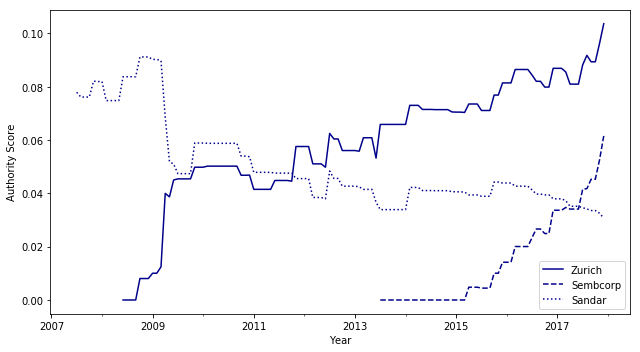

In [374]:
plt.figure(figsize=(9,5))
styles = ('-', '--', ':')
labels = ('Zurich', 'Sembcorp', 'Sandar')
for i, case in enumerate(key_cases):
    contract_ts[case]['authority_score'].plot(label=labels[i], linestyle=styles[i], color='darkblue')
    plt.legend()

plt.ylabel('Authority Score')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('Images/zurich_ts.png')

In [367]:
key_cases = (987,737,722)
_, global_ts = analyze_one_topic(edge_df, meta_df, '', '', key_cases, with_prompts=False)

Analyzing global data as no topic was supplied
Getting rank scores for topic
Plotting growth trajectory of selected cases...
Getting scores for case Zurich Insurance (Singapore) Pte Ltd v B-Gold Interior Design & Construction Pte Ltd
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...
Getting scores for case Sembcorp Marine Ltd v PPL Holdings Pte Ltd and another and another appeal
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...
Getting scores for case Sandar Aung v Parkway Hospitals Singapore Pte Ltd (trading as Mount Elizabeth Hospital) and another
Getting in_degree_cent over time...
Getting hub_score over time...
Getting authority_score over time...


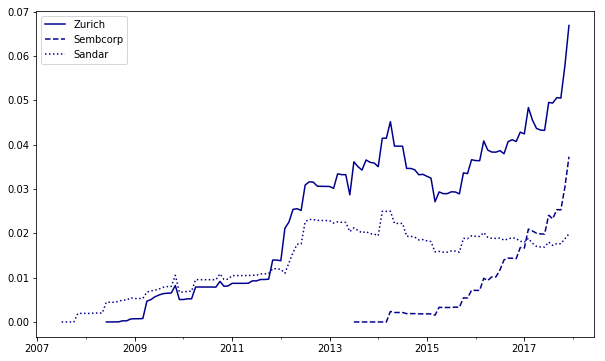

In [369]:
plt.figure(figsize=(10,6))
styles = ('-', '--', ':')
labels = ('Zurich', 'Sembcorp', 'Sandar')
for i, case in enumerate(key_cases):
    global_ts[case]['authority_score'].plot(label=labels[i], linestyle=styles[i], color='darkblue')
    plt.legend()

In [355]:
find_cases_citing(722, edge_df[edge_df['citing_has_topic_contract']==1])

['Sunny Metal & Engineering Pte Ltd v Ng Khim Ming Eric [2007] 3 SLR(R) 782',
 'Y.E.S. F&B Group Pte Ltd v Soup Restaurant Singapore Pte Ltd (formerly known as Soup Restaurant (Causeway Point) Pte Ltd) [2015] 5 SLR 1187',
 'Chua Chian Ya v Music & Movements (S) Pte Ltd (formerly trading as M\xa0&\xa0M Music Publishing) [2010] 1 SLR 607',
 'Smile Inc Dental Surgeons Pte Ltd v Lui Andrew Stewart [2012] 4 SLR 308',
 'Man Financial (S) Pte Ltd (formerly known as E\xa0D & F\xa0Man International (S) Pte Ltd) v Wong Bark Chuan David [2008] 1 SLR(R) 663',
 'KS\xa0Energy Services Ltd v BR\xa0Energy (M) Sdn Bhd [2014] 2 SLR 905',
 'Zurich Insurance (Singapore) Pte Ltd v B-Gold Interior Design & Construction Pte Ltd [2008] 3 SLR(R) 1029',
 'Ong Chay Tong & Sons (Pte) Ltd v Ong Hoo Eng [2009] 1 SLR(R) 305']

In [356]:
find_cases_citing(987, edge_df[edge_df['citing_has_topic_contract']==1])

['Sembcorp Marine Ltd v PPL Holdings Pte Ltd and another and another appeal [2013] 4 SLR 193',
 'Ng Giap Hon v Westcomb Securities Pte Ltd and others [2009] 3 SLR(R) 518',
 'Centre for Laser and Aesthetic Medicine Pte Ltd v GPK Clinic (Orchard) Pte Ltd and others and another appeal [2018] 1 SLR 180',
 'CIFG Special Assets Capital I Ltd (formerly known as Diamond Kendall Ltd) v Ong Puay Koon and others and another appeal [2018] 1 SLR 170',
 'Hewlett-Packard Singapore (Sales) Pte Ltd v Chin Shu Hwa Corinna [2016] 2 SLR 1083',
 'Lucky Realty Co Pte Ltd v HSBC Trustee (Singapore) Ltd [2016] 1 SLR 1069',
 'Ngee Ann Development Pte Ltd v Takashimaya Singapore Ltd [2017] 2 SLR 627',
 'Xia Zhengyan v Geng Changqing [2015] 3 SLR 732',
 'Y.E.S. F&B Group Pte Ltd v Soup Restaurant Singapore Pte Ltd (formerly known as Soup Restaurant (Causeway Point) Pte Ltd) [2015] 5 SLR 1187',
 'Yap Son On v Ding Pei Zhen [2017] 1 SLR 219',
 'Lee Wei Ling and another v Attorney-General [2017] 2 SLR 786',
 'Ang T

Plotting overall graph as direct and undirected graphs...


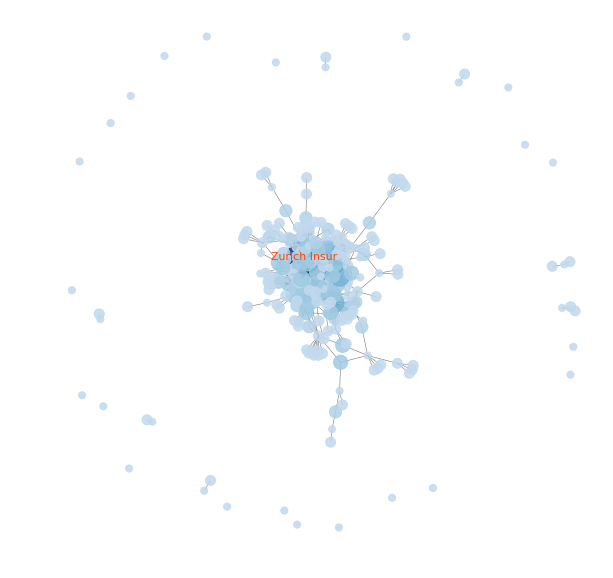

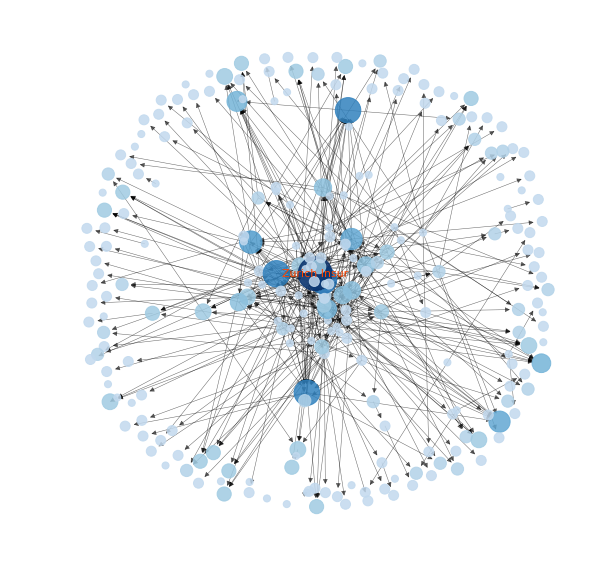

Plotting centrality histogram for top cases...


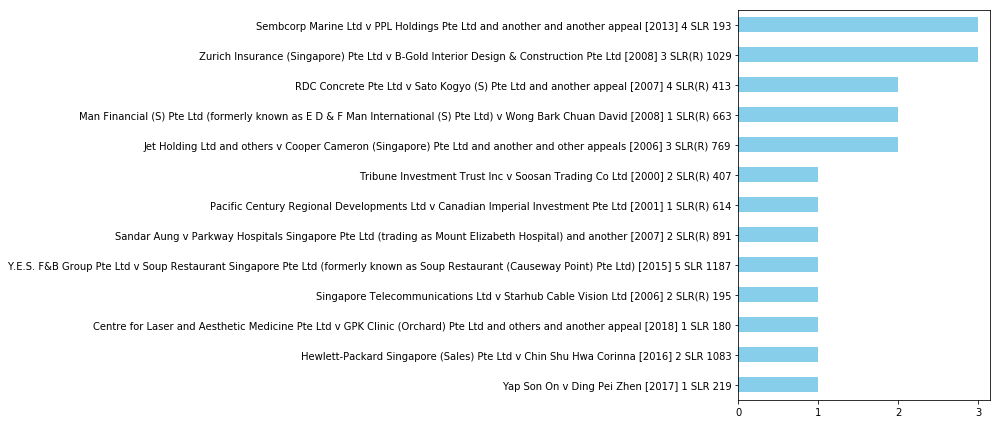

Plotting yearly growth trajectory of topic...


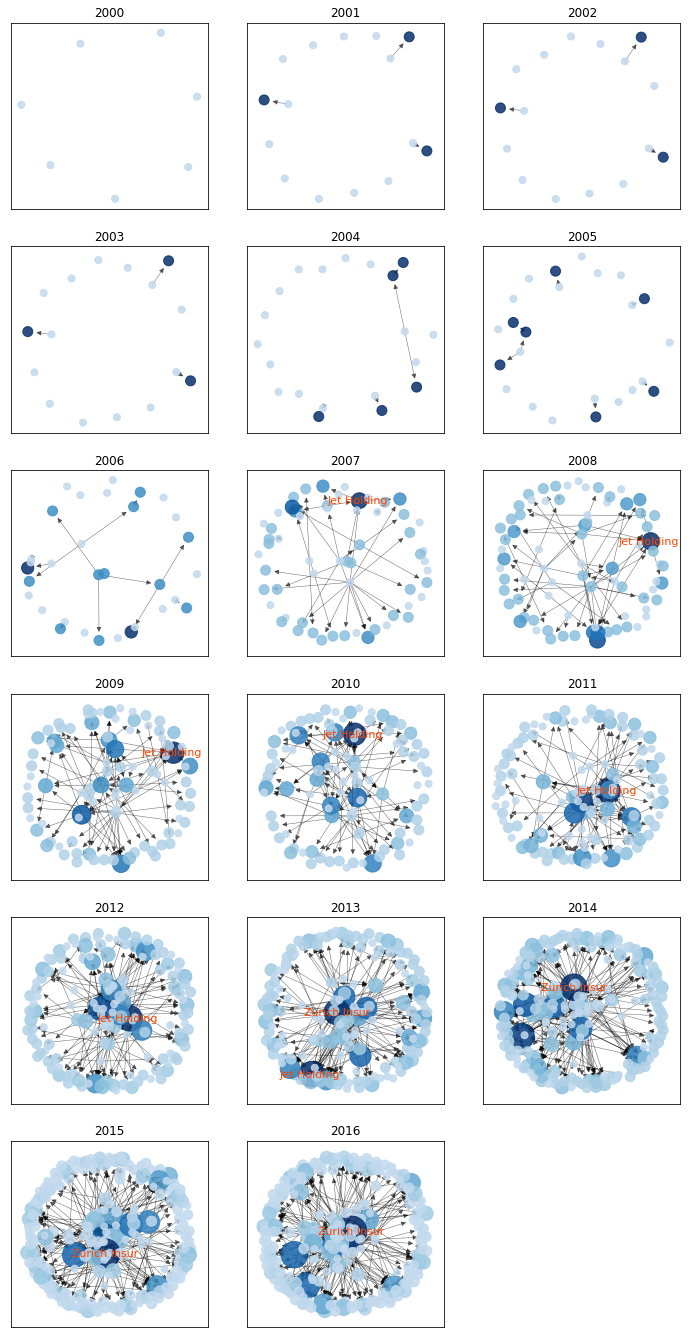

Plotting growth trajectory of top cases...
Getting scores for case Pacific Century Regional Developments Ltd v Canadian Imperial Investment Pte Ltd
Getting in_degree_cent over time...
Getting pagerank over time...
Getting hub_score over time...
Getting authority_score over time...


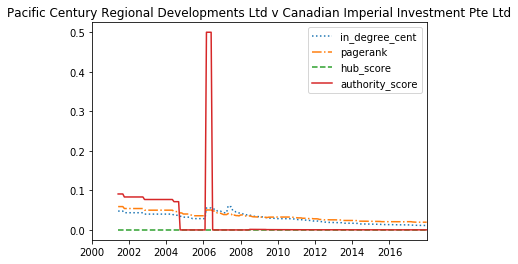

Getting scores for case Zurich Insurance (Singapore) Pte Ltd v B-Gold Interior Design & Construction Pte Ltd
Getting in_degree_cent over time...
Getting pagerank over time...
Getting hub_score over time...
Getting authority_score over time...


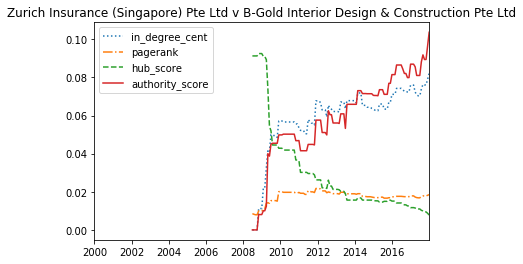

Getting scores for case Wee Chiaw Sek Anna v Ng Li-Ann Genevieve (sole executrix of the estate of Ng Hock Seng, deceased) and another
Getting in_degree_cent over time...
Getting pagerank over time...
Getting hub_score over time...
Getting authority_score over time...


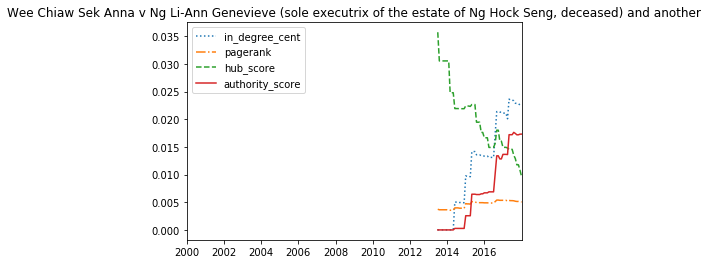

Getting scores for case Sembcorp Marine Ltd v PPL Holdings Pte Ltd and another and another appeal
Getting in_degree_cent over time...
Getting pagerank over time...
Getting hub_score over time...
Getting authority_score over time...


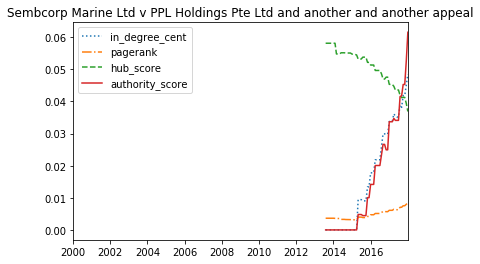

In [34]:
contract_central_cases, contract_top_cases = analyze_one_topic(edge_df, 'contract', 'citing_has_topic_contract', with_prompts=False)

In [39]:
contract_central_cases

,in_degree,in_degree_cent,out_degree,out_degree_cent,pagerank,hub_score,authority_score
0,987.0,987.0,940.0,940.0,585.0,737.0,987.0
1,688.0,688.0,6.0,6.0,987.0,294.0,737.0
2,737.0,737.0,606.0,606.0,332.0,969.0,462.0
3,332.0,332.0,791.0,791.0,910.0,964.0,688.0
4,462.0,462.0,539.0,539.0,761.0,119.0,722.0


In [40]:
eda.convert_id_df_to_case_names(contract_central_cases)

,in_degree,in_degree_cent,out_degree,out_degree_cent,pagerank,hub_score,authority_score
0,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...,Wee Chiaw Sek Anna v Ng Li-Ann Genevieve (sole...,Wee Chiaw Sek Anna v Ng Li-Ann Genevieve (sole...,Pacific Century Regional Developments Ltd v Ca...,Sembcorp Marine Ltd v PPL Holdings Pte Ltd and...,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...
1,RDC Concrete Pte Ltd v Sato Kogyo (S) Pte Ltd ...,RDC Concrete Pte Ltd v Sato Kogyo (S) Pte Ltd ...,ACB v Thomson Medical Pte Ltd and others,ACB v Thomson Medical Pte Ltd and others,Zurich Insurance (Singapore) Pte Ltd v B-Gold ...,Hewlett-Packard Singapore (Sales) Pte Ltd v Ch...,Sembcorp Marine Ltd v PPL Holdings Pte Ltd and...
2,Sembcorp Marine Ltd v PPL Holdings Pte Ltd and...,Sembcorp Marine Ltd v PPL Holdings Pte Ltd and...,PH Hydraulics & Engineering Pte Ltd v Airtrust...,PH Hydraulics & Engineering Pte Ltd v Airtrust...,Jet Holding Ltd and others v Cooper Cameron (S...,Yap Son On v Ding Pei Zhen,Man Financial (S) Pte Ltd (formerly known as E...
3,Jet Holding Ltd and others v Cooper Cameron (S...,Jet Holding Ltd and others v Cooper Cameron (S...,Sunny Metal & Engineering Pte Ltd v Ng Khim Mi...,Sunny Metal & Engineering Pte Ltd v Ng Khim Mi...,Tribune Investment Trust Inc v Soosan Trading ...,Y.E.S. F&B Group Pte Ltd v Soup Restaurant Sin...,RDC Concrete Pte Ltd v Sato Kogyo (S) Pte Ltd ...
4,Man Financial (S) Pte Ltd (formerly known as E...,Man Financial (S) Pte Ltd (formerly known as E...,Ng Giap Hon v Westcomb Securities Pte Ltd and ...,Ng Giap Hon v Westcomb Securities Pte Ltd and ...,Singapore Telecommunications Ltd v Starhub Cab...,Centre for Laser and Aesthetic Medicine Pte Lt...,Sandar Aung v Parkway Hospitals Singapore Pte ...
